## Imports

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
from sqlalchemy import create_engine, MetaData, text
import json
from io import StringIO

---

## Carga de los dataset

In [80]:
# Optamos por cargar el primer dataset (datos metereológicos desde 1991 a 2020) desde un archivo excel que obtuvimos del sitio oficial
# del SMN: https://www.smn.gob.ar/descarga-de-datos. 
# # Saltamos las primeras 4 filas porque contienen información no relevante para el análisis.
df_91_20_wide = pd.read_excel("Estadísticas normales Datos abiertos 1991-2020.xlsx", skiprows=4)

#El segundo dataset corresponde a datos de temperatura de los últimos 365 días y lo cargamos desde un archivo de texto obtenido en el mismo sitio.
#Además salteamos las primeras 3 filas que contienen información no relevante y renombramos las columnas para que coincidan.

df_365 = pd.read_fwf("registro_temperatura365d_smn.txt", skiprows=3, names=["FECHA", "Temperatura Máx.", "Temperatura Mín.", "Estación"], encoding="latin1")


---

## Arreglo de los dataset

### Dataset 1991-2020

Encontramos dos problemas iniciales con este dataset: 
1. La forma en que se indican los datos faltantes es con la indicación "S/D", no reconocida por Pandas. 

2. La información se encuentra en un formato ancho ("wide format") donde no cumple con el formato "tidy" ideal para modelos de ML. 

In [81]:
# Primero solucionamos el problema de la referencia a los valores faltantes.
for col in df_91_20_wide.columns[2:]:
    df_91_20_wide[col] = (
        df_91_20_wide[col]
        .replace("S/D", pd.NA)          
    )

In [82]:
#Ahora solucionamos el segundo problema transformando el dataset en un formato long en el que cada variable tenga su propia columna 
# y cada observación su propia fila.

# Convertimos de formato wide a long con el método melt de pandas.
df_long= df_91_20_wide.melt(id_vars=['Estación', 'Valor Medio de'], var_name='Mes', value_name='Valor')
# Ahora pivoteamos para que las métricas sean columnas
df_91_20_tidy = df_long.pivot_table(index=['Estación', 'Mes'], columns='Valor Medio de', values='Valor').reset_index()

#Simplificamos algunos nombres de columnas.
df_91_20_tidy.rename(columns={
    'Humedad relativa (%)': 'Humedad relativa',
    'Nubosidad total (octavos)': 'Nubosidad total',
    'Precipitación (mm)': 'Precipitación',
    'Frecuencia de días con Precipitación superior a 1.0 mm': 'Prec. > a 1.0 mm',
    'Temperatura (°C)': 'Temperatura',
    'Temperatura máxima (°C)': 'Temperatura Máx.',
    'Temperatura mínima (°C)': 'Temperatura Mín.',
    'Velocidad del Viento (km/h) (2011-2020)': 'Viento'
}, inplace=True)

df_91_20_tidy.head()

Valor Medio de,Estación,Mes,Prec. > a 1.0 mm,Humedad relativa,Nubosidad total,Precipitación,Temperatura,Temperatura Máx.,Temperatura Mín.,Viento
0,AEROPARQUE AERO,Abr,6.6,73.6,3.5,108.3,18.5,22.0,15.3,13.9
1,AEROPARQUE AERO,Ago,5.0,73.6,3.9,61.5,12.9,16.5,9.7,14.0
2,AEROPARQUE AERO,Dic,6.6,65.1,3.2,112.8,23.2,27.4,19.2,15.9
3,AEROPARQUE AERO,Ene,6.7,67.0,3.1,117.5,24.5,28.4,20.8,16.8
4,AEROPARQUE AERO,Feb,6.0,69.8,3.2,112.3,23.7,27.3,20.2,15.8


Luego de esto podemos ver la diferencia entre cómo estaban arreglados los datos antes y cómo lo están ahora:

Arreglo inicial: 
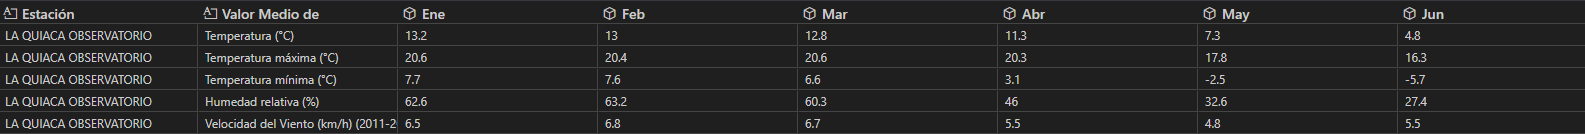

Arreglo tidy: 
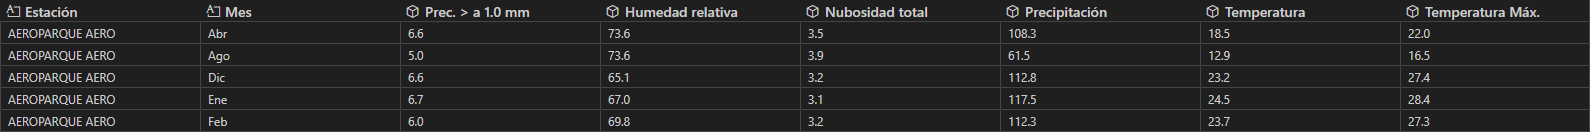

Puede notarse cómo ahora cada variable tiene su propia columna haciendo más fácil la selección de los Features y de la variable objetivo para el entrenamiento. Las primeras dos columnas actúan como una doble ID para las entradas, formadas por "Estación" + "Mes", de esta manera cada observación
corresponde a una estación determinada en un mes determinado. 

### Dataset de los últimos 365 días

Ahora debemos acomodar este segundo dataset para que sea compatible con el primero ya que vamos a hacer comparaciones entre ambos.

Observaciones: 

1. En los dos dataset figuran los datos de temperatura máxima y mínima que son los datos que vamos a comparar.


2. En el dataset de los últimos 365 días los datos están acomodados por día, a diferencia de las mediciones mensuales del primer dataset. Para solucionar esto elegimos agrupar las mediciones del segundo dataset en meses contando hasta el mes pasado (abril de 2025) ya que mayo no está completo.

3. También nos enfrentamos al problema de las estaciones en donde se realizaron las mediciones, en ambos dataset los nombres de algunas estaciones varían y también, como puede verse a continuación, la cantidad de estaciones es diferente.  

In [83]:
print("Cantidad de estaciones en dataset 91-20: ", df_91_20_tidy["Estación"].nunique())
print("Cantidad de estaciones en dataset 365: ", df_365["Estación"].nunique())

Cantidad de estaciones en dataset 91-20:  98
Cantidad de estaciones en dataset 365:  118


Por esta razón hemos decidido promediar las mediciones entre todas las estaciones para cada dataset a la hora de establecer las comparaciones entre ellos más adelante.

In [84]:
# Primero convertimos FECHA al formato datetime y agrupamos por meses.
df_365["FECHA"] = pd.to_datetime(df_365["FECHA"], format="%d%m%Y", errors='coerce')
df_365["Mes"] = df_365["FECHA"].dt.to_period("M")

# Eliminamos las filas correspondientes a mayo de 2025 y a enero, febrero, marzo y abril de 2024, para no tener mediciones de meses repetidas.
meses_a_excluir = ["2025-05", "2024-01", "2024-02", "2024-03", "2024-04"]
df_365 = df_365[~df_365["Mes"].isin(meses_a_excluir)]

#Eliminamos los datos faltantes. Siendo sólo el 1% de los datos, no es un problema para el análisis.
df_365 = df_365.dropna(axis=0)

#Ahora reemplazamos los valores de la columna "Mes" por los nombres de los meses para que coincida a cómo está en el otro dataframe.
meses = {
    '01': 'Ene',
    '02': 'Feb',
    '03': 'Mar',
    '04': 'Abr',
    '05': 'May',
    '06': 'Jun',
    '07': 'Jul',
    '08': 'Ago',
    '09': 'Sep',
    '10': 'Oct',
    '11': 'Nov',
    '12': 'Dic'
}

df_365['Mes'] = df_365['FECHA'].dt.strftime('%m').map(meses)

# Calculamos el promedio mensual de las temperaturas máximas y mínimas entre todas las estaciones juntas
df_365_tidy = df_365.groupby("Mes")[["Temperatura Máx.", "Temperatura Mín."]].mean().round(1)

df_365_tidy.head()

,Temperatura Máx.,Temperatura Mín.
Mes,,
Abr,20.5,9.3
Ago,15.7,3.7
Dic,27.1,13.7
Ene,29.4,15.8
Feb,29.1,16.3


Finalmente quedamos con los dos dataset en un formato compatible para la comparación de las temperaturas máximas y mínimas promediadas mensualmente.

El EDA que realizaremos a continuación, de todas maneras, estará centrado en el dataset 91-20 ya que es mucho más rico en información que el otro, al que sólo usaremos para dicha comparación. 



In [85]:
#Para finalizar renombramos ambos datasets para trabajar con ellos y reordenamos las columnas de df_91_20. 
df_91_20 = df_91_20_tidy

nuevo_orden = ['Estación',                   #Variables de id      
               'Mes',                               
               'Precipitación',              #Variables climáticas
               'Prec. > a 1.0 mm', 
               'Humedad relativa', 
               'Nubosidad total', 
               'Viento',              
               'Temperatura',                #Variables de temperatura
               'Temperatura Máx.',
               'Temperatura Mín.',
]

df_91_20 = df_91_20_tidy[nuevo_orden]

*Nota: entendemos que las mediciones de temperatura también son consideradas parte del clima, pero elegimos esta clasificación para diferenciar aquellas variables estrictamente ligadas a la temperatura de las demás.*

---

## EDA

#### Descripción del dataset 91-20
Todas las variables son de tipo **numéricas continuas** salvo las dos primeras columnas que son **categóricas**.

| Columna            | Descripción                                                                         |
| -------------      | ------------------------------------------------------------------------------------|
| `Estación`         | El nombre de la estación desde donde se tomaron los datos.                          |
| `Mes`              | El mes al que corresponden las mediciones.                                          |
| Mediciones         | ------------------------------------------------------------------------------------|
| `Precipitación`    | La precipitación, en milímetros.                                                    | 
| `Prec. > a 1.0 mm` | Cantidad de días que llovió más de 1 milímetro.                                     |
| `Humedad relativa` | La humedad relativa.                                                                | 
| `Nubosidad total`  | La nubosidad, expresada en octavos.                                                 | 
| `Viento`           | La velocidad del viento, en km/h.                                                   | 
| `Temperatura`      | La temperatura promedio, en °C.                                                     | 
| `Temperatura Máx.` | La temperatura máxima, en °C.                                                       | 
| `Temperatura Mín.` | La temperatura mínima, en °C.                                                       | 

**Ahora vemos la cantidad de entradas del dataset junto con una muestra del mismo.**


In [86]:
# Ahora vemos la cantidad de entradas del dataset.
print("Cantidad de muestras: ", df_91_20.shape[0])
print("Muestra: ")
df_91_20.head(10)


Cantidad de muestras:  1171
Muestra: 


Valor Medio de,Estación,Mes,Precipitación,Prec. > a 1.0 mm,Humedad relativa,Nubosidad total,Viento,Temperatura,Temperatura Máx.,Temperatura Mín.
0,AEROPARQUE AERO,Abr,108.3,6.6,73.6,3.5,13.9,18.5,22.0,15.3
1,AEROPARQUE AERO,Ago,61.5,5.0,73.6,3.9,14.0,12.9,16.5,9.7
2,AEROPARQUE AERO,Dic,112.8,6.6,65.1,3.2,15.9,23.2,27.4,19.2
3,AEROPARQUE AERO,Ene,117.5,6.7,67.0,3.1,16.8,24.5,28.4,20.8
4,AEROPARQUE AERO,Feb,112.3,6.0,69.8,3.2,15.8,23.7,27.3,20.2
5,AEROPARQUE AERO,Jul,64.3,5.0,75.5,4.1,13.2,11.3,14.4,8.4
6,AEROPARQUE AERO,Jun,54.6,4.5,76.3,4.2,12.2,12.3,15.5,9.4
7,AEROPARQUE AERO,Mar,111.8,5.9,71.3,3.1,14.9,22.0,25.5,18.8
8,AEROPARQUE AERO,May,83.3,5.0,76.4,4.0,12.9,15.2,18.4,12.3
9,AEROPARQUE AERO,Nov,103.2,6.8,67.0,3.5,17.1,20.6,24.5,16.8


**Ajustamos los tipos de datos de las columnas numéricas que en este momento siguen siendo de tipo *object***.

In [87]:
df_91_20['Precipitación'] = df_91_20['Precipitación'].astype('float64')
df_91_20['Prec. > a 1.0 mm'] = df_91_20['Prec. > a 1.0 mm'].astype('float64')
df_91_20['Humedad relativa'] = df_91_20['Humedad relativa'].astype('float64')
df_91_20['Nubosidad total'] = df_91_20['Nubosidad total'].astype('float64')
df_91_20['Viento'] = df_91_20['Viento'].astype('float64')
df_91_20['Temperatura'] = df_91_20['Temperatura'].astype('float64')
df_91_20['Temperatura Máx.'] = df_91_20['Temperatura Máx.'].astype('float64')
df_91_20['Temperatura Mín.'] = df_91_20['Temperatura Mín.'].astype('float64')

df_91_20.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1171 entries, 0 to 1170
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Estación          1171 non-null   object 
 1   Mes               1171 non-null   object 
 2   Precipitación     1061 non-null   float64
 3   Prec. > a 1.0 mm  1061 non-null   float64
 4   Humedad relativa  1110 non-null   float64
 5   Nubosidad total   1166 non-null   float64
 6   Viento            708 non-null    float64
 7   Temperatura       1167 non-null   float64
 8   Temperatura Máx.  1158 non-null   float64
 9   Temperatura Mín.  1124 non-null   float64
dtypes: float64(8), object(2)
memory usage: 91.6+ KB


---

## Exploración de las variables categóricas

**Variable 'Estaciones':** 

Como ya hemos dicho antes esta variable tiene 98 valores únicos cada uno correspondiente a una estación desde donde se registraron los datos del dataset. Para nosotros esta variable no reviste mucho interés porque no se puede extraer demasiado significado de ella, sería interesante por ejemplo, que las estaciones estuvieran agrupadas por provincia o región del país para poder sacar conclusiones más significativas pero lamentablemente no es el caso. 

**Variable 'Meses':**

Esta variable es simplemente una variable categórica que representa los meses del año y se puede utilizar para hacer análisis interesantes y sacar conclusiones sobre cómo varían las diferentes facetas del clima en función de ellos y de las estaciones del año.

Dado que ambas variables funcionan como Id no tienen valores faltantes.

In [88]:
print(df_91_20["Estación"].isna().sum())
print(df_91_20["Mes"].isna().sum())

0
0


---

## Exploración de las variables numéricas

Primero realizamos una descripción general de las mismas.



In [89]:
df_91_20.describe()

Valor Medio de,Precipitación,Prec. > a 1.0 mm,Humedad relativa,Nubosidad total,Viento,Temperatura,Temperatura Máx.,Temperatura Mín.
count,1061.000000,1061.000000,1110.000000,1166.000000,708.000000,1167.000000,1158.000000,1124.000000
mean,68.234873,5.097455,68.005405,3.840137,13.011582,14.834190,21.223834,9.102847
std,51.674519,2.536586,11.027475,0.888284,5.554040,8.178787,8.938676,7.778743
min,0.000000,0.000000,25.700000,1.300000,3.900000,-20.900000,-17.500000,-25.000000
25%,23.300000,3.100000,61.325000,3.300000,9.200000,10.300000,17.025000,4.500000
50%,58.900000,5.200000,70.100000,3.700000,11.800000,15.700000,22.400000,9.900000
75%,106.500000,7.000000,76.400000,4.200000,15.900000,21.200000,27.900000,15.100000
max,277.900000,13.800000,90.200000,7.500000,36.500000,28.300000,35.500000,22.500000


---

### Variables numéricas "climáticas" (no relacionadas a la temperatura)
**Viento:**


A simple vista se puede ver que la variable **viento** tiene una gran cantidad de valores nulos.

In [90]:

print("Porcentaje de datos faltantes en la columna viento: ", (df_91_20["Viento"].isna().sum()*100/df_91_20.shape[0]).__round__(2), "%")

Porcentaje de datos faltantes en la columna viento:  39.54 %


El porcentaje de entradas que no tienen un valor de viento es del 39%. Tenemos la sospecha de que esto pueda deberse a que haya estaciones donde directamente no se haya realizado esa medición, y no porque las mediciones hayan sido erráticas, verifiquemos:

In [91]:
# Filtramos las estaciones que tienen datos de viento.
estaciones_con_viento = df_91_20[df_91_20["Viento"].notnull()]["Estación"].unique()

# Contamos el porcentaje de estaciones que tienen datos de viento.
porcentaje_estaciones_con_viento = (len(estaciones_con_viento) / df_91_20["Estación"].nunique()) * 100

print("Porcentaje de estaciones que no midieron el viento:", 100 - porcentaje_estaciones_con_viento.__round__(2), "%")

Porcentaje de estaciones que no midieron el viento: 39.8 %


Dado que el porcentaje de estaciones que no midieron el viento coincide casi exactamente con el porcentaje de datos faltantes en esa columna podemos aventurarnos a asegurar que la falta de esos datos se debe a esa razón. Elegimos representar esto con una flag que indique si el viento fue medido o no. 

Lamentablemente la cantidad de faltantes es muy elevada como para realizar una imputación.

In [92]:
df_91_20["Viento_medido"] = df_91_20["Viento"].notnull()

**Precipitación y Prec. > a 1.0 mm:**

Otras variables que llamaron nuestra atención son **precipitación** y **prec. > a 1.0 mm**, ambas tienen también una cantidad considerable de datos faltantes:

In [93]:
print("Porcentaje de datos faltantes en la columna Precipitación: ", (df_91_20["Precipitación"].isna().sum()*100/df_91_20.shape[0]).__round__(2), "%")
print("Porcentaje de datos faltantes en la columna Prec. > a 1.0 mm: ", (df_91_20["Prec. > a 1.0 mm"].isna().sum()*100/df_91_20.shape[0]).__round__(2), "%")


Porcentaje de datos faltantes en la columna Precipitación:  9.39 %
Porcentaje de datos faltantes en la columna Prec. > a 1.0 mm:  9.39 %


Como era esperable el porcentaje de faltantes entre ambas columnas coincide. Decidimos imputar ambos valores utilizando la media mensual (durante los años de medición del dataset) para las dos columnas ya que el porcentaje de valores faltantes es bajo:

In [94]:
df_91_20['Precipitación'] = df_91_20.groupby('Mes')['Precipitación'].transform(lambda x: x.fillna(x.mean()))
df_91_20['Prec. > a 1.0 mm'] = df_91_20.groupby('Mes')['Prec. > a 1.0 mm'].transform(lambda x: x.fillna(x.mean()))

**Humedad relativa:** 

In [95]:
print("Porcentaje de datos faltantes en la columna Humedad relativa: ", (df_91_20["Humedad relativa"].isna().sum()*100/df_91_20.shape[0]).__round__(2), "%")

Porcentaje de datos faltantes en la columna Humedad relativa:  5.21 %


Usando el mismo criterio que para las dos variables anteriores imputamos este 5% de datos faltantes con la media:

In [96]:
df_91_20['Humedad relativa'] = df_91_20.groupby('Mes')['Humedad relativa'].transform(lambda x: x.fillna(x.mean()))

**Promedios mensuales:**

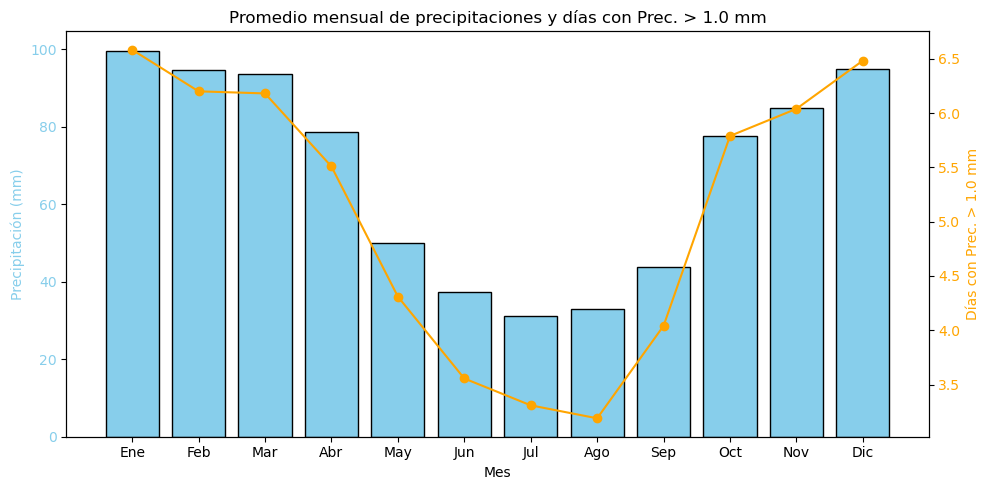

In [97]:
# Queremos ver un gráfico que represente el promedio de precipitaciones por mes entre 1991 y 2020 
# junto con la cantidad de días con mediciones mayores a 1mm.

# Para eso primero sacamos el promedio para cada mes. 
df_prom_mensual_precipitacion = df_91_20.groupby('Mes')['Precipitación'].mean()
df_prom_mensual_prec_gt_1mm = df_91_20.groupby('Mes')["Prec. > a 1.0 mm"].mean()

# Reodrenamos los dataset
meses_orden = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 
               'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']
df_prom_mensual_ordenado = df_prom_mensual_precipitacion.reindex(meses_orden)
df_prec_gt1_ordenado = df_prom_mensual_prec_gt_1mm.reindex(meses_orden)


# Gráficamos
fig, ax1 = plt.subplots(figsize=(10, 5))

# Barras: Precipitación
ax1.bar(df_prom_mensual_ordenado.index, df_prom_mensual_ordenado.values, color='skyblue', edgecolor='black', label='Precipitación (mm)')
ax1.set_xlabel('Mes')
ax1.set_ylabel('Precipitación (mm)', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')

# Línea de Prec. > 1.0 mm
ax2 = ax1.twinx()
ax2.plot(df_prec_gt1_ordenado.index, df_prec_gt1_ordenado.values, color='orange', marker='o', label='Prec. > 1.0 mm')
ax2.set_ylabel('Días con Prec. > 1.0 mm', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title('Promedio mensual de precipitaciones y días con Prec. > 1.0 mm')
fig.tight_layout()
plt.show()

Este gráfico puede sugerir que tan distribuídas se hayan las lluvias en cada mes, viendose que en los meses desde mayo a septiembre no sólo llueve menos si no que dichas lluvias se hayan más distribuídas entre los días del mes. 

---

### Variables numéricas de temperatura
**Vamos a tratar y analizar las tres variables que miden la temperatura juntas:**

In [98]:
df_91_20[['Temperatura', 'Temperatura Máx.', 'Temperatura Mín.']].describe()

Valor Medio de,Temperatura,Temperatura Máx.,Temperatura Mín.
count,1167.000000,1158.000000,1124.000000
mean,14.834190,21.223834,9.102847
std,8.178787,8.938676,7.778743
min,-20.900000,-17.500000,-25.000000
25%,10.300000,17.025000,4.500000
50%,15.700000,22.400000,9.900000
75%,21.200000,27.900000,15.100000
max,28.300000,35.500000,22.500000


Encontramos que las mediciones de temperatura mínima tienen una cantidad de nulos del 4%, nos llama la atención que no se encuentre ese mismo fenómeno en las otras dos variables, sobre todo en la temperatura máxima puesto a que es una variable que se esperaría que "haga juego" con la temperatura mínima:

In [99]:
print("Porcentaje de datos faltantes en la columna viento: ", (df_91_20["Temperatura"].isna().sum()*100/df_91_20.shape[0]).__round__(2), "%")
print("Porcentaje de datos faltantes en la columna viento: ", (df_91_20["Temperatura Máx."].isna().sum()*100/df_91_20.shape[0]).__round__(2), "%")
print("Porcentaje de datos faltantes en la columna viento: ", (df_91_20["Temperatura Mín."].isna().sum()*100/df_91_20.shape[0]).__round__(2), "%")

Porcentaje de datos faltantes en la columna viento:  0.34 %
Porcentaje de datos faltantes en la columna viento:  1.11 %
Porcentaje de datos faltantes en la columna viento:  4.01 %


Partimos de la hipótesis de que, tal vez, esa falta de datos en las temperaturas mínimas se debieran a temperaturas muy bajas que por algún motivo técnico impidieran las mediciones en los lugares más fríos. Para ello, como puede verse a continuación, agrupamos los valores nulos de esta variable por mes para ver si el % de faltantes se agrupa en los meses más fríos:

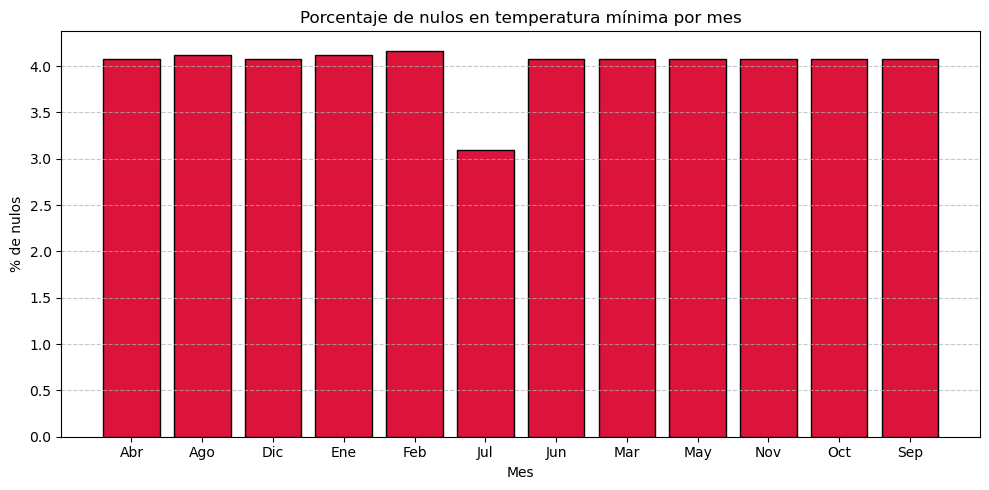

In [100]:
# Contamos la cantidad de registros por mes
total_por_mes = df_91_20['Mes'].value_counts().sort_index()

# Cuántos nulos hay en la temperatura mínima por mes
nulos_temp_min_por_mes = df_91_20[df_91_20['Temperatura Mín.'].isnull()]['Mes'].value_counts().sort_index()

# Calculamos el porcentaje de nulos por mes
porcentaje_nulos_por_mes = (nulos_temp_min_por_mes / total_por_mes * 100).fillna(0)


plt.figure(figsize=(10, 5))
plt.bar(porcentaje_nulos_por_mes.index, porcentaje_nulos_por_mes.values, color='crimson', edgecolor='black')
plt.title('Porcentaje de nulos en temperatura mínima por mes')
plt.xlabel('Mes')
plt.ylabel('% de nulos')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


A raíz del resultado no sólo vemos que nuestra hipótesis no es válida si no que se presenta el caso opuesto: el mes más frío del año posee la menor cantidad de datos nulos de temperatura mínima. Esto pareciera indicar que los valores faltantes no se deben a la incapacidad de medición para valores muy fríos si no que tal vez sea una cuestión de interés, donde en el mes más frío sea más importante medir las temperaturas mínimas, por supuesto, todo esto dentro del campo de la especulación. 

**Graficamos la distribución de las cariables de temperatura:**

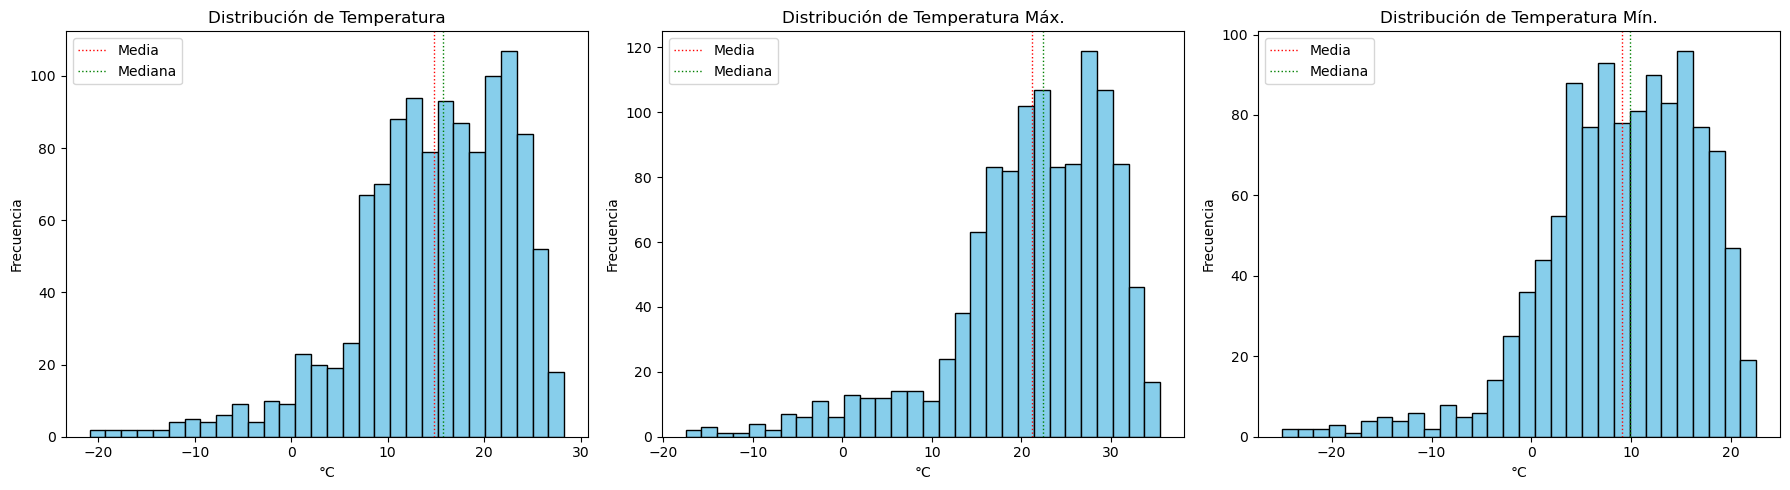

In [101]:

fig, axs = plt.subplots(1, 3, figsize=(18, 5))
columnas = ['Temperatura', 'Temperatura Máx.', 'Temperatura Mín.']

for i, col in enumerate(columnas):
    axs[i].hist(df_91_20[col].dropna(), bins=30, color='skyblue', edgecolor='black')
    axs[i].set_title(f'Distribución de {col}')
    axs[i].set_xlabel('°C')
    axs[i].set_ylabel('Frecuencia')
    media = df_91_20[col].mean()
    mediana = df_91_20[col].median()
    axs[i].axvline(media, color='red', linestyle='dotted', linewidth=1, label='Media')
    axs[i].axvline(mediana, color='green', linestyle='dotted', linewidth=1, label='Mediana')
    axs[i].legend()

plt.tight_layout()
plt.show()

La distribución en los tres casos muestra una pronunciada skewness hacia la izquierda (sesgo negativo), lo que indica que hay algunos días fríos extremos inculso en las mediciones de temperatura máxima. Además la media se encuentra siempre a la izquierda de la mediana, lo que confirma el sesgo negativo.

---

## Analisis de Outliers

### Métodos de detección

In [102]:
# Método 1: IQR (Rango por Intercuartílico)
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]

### Visualización

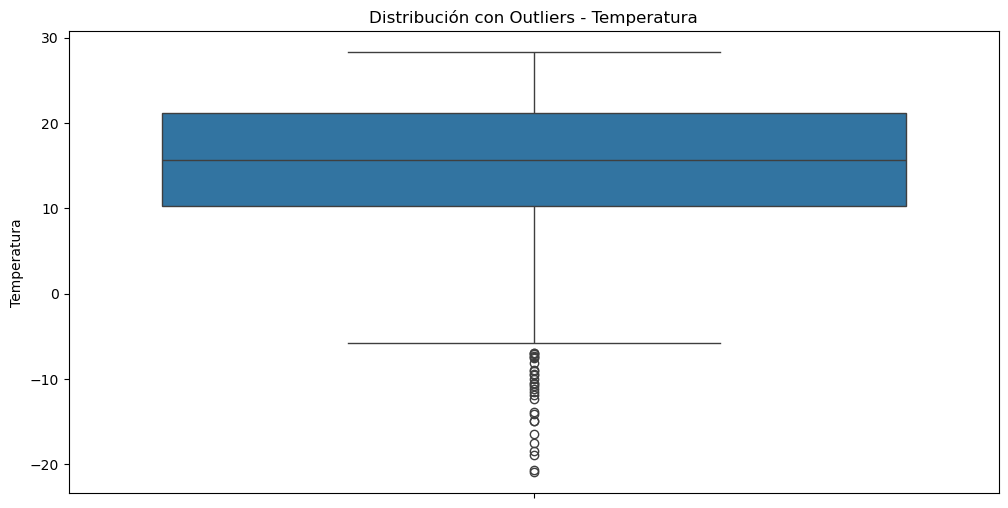

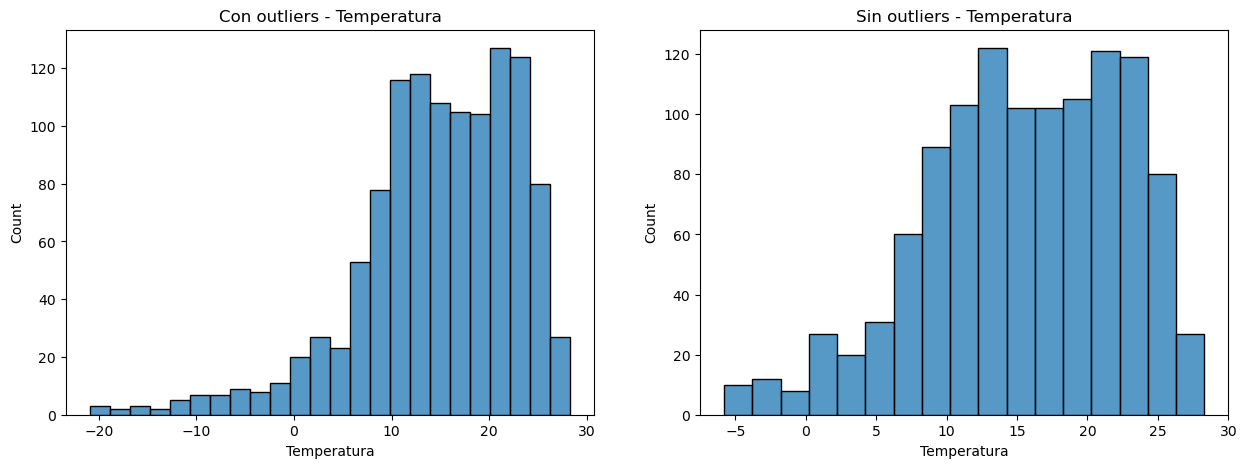

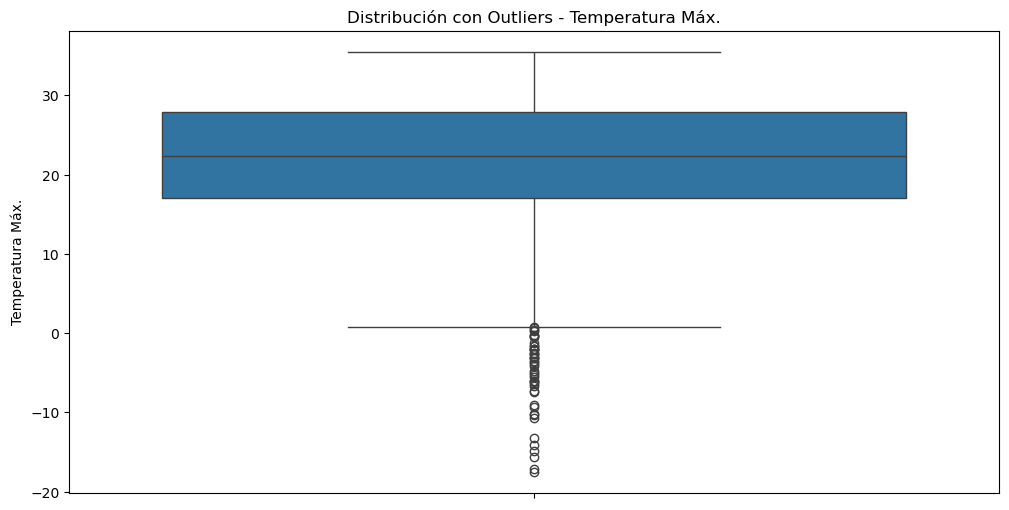

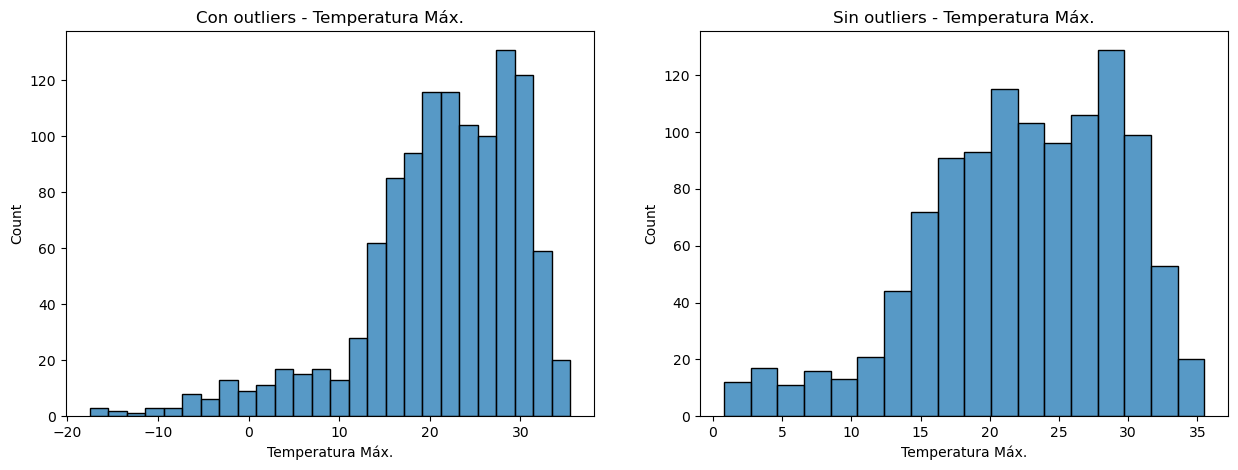

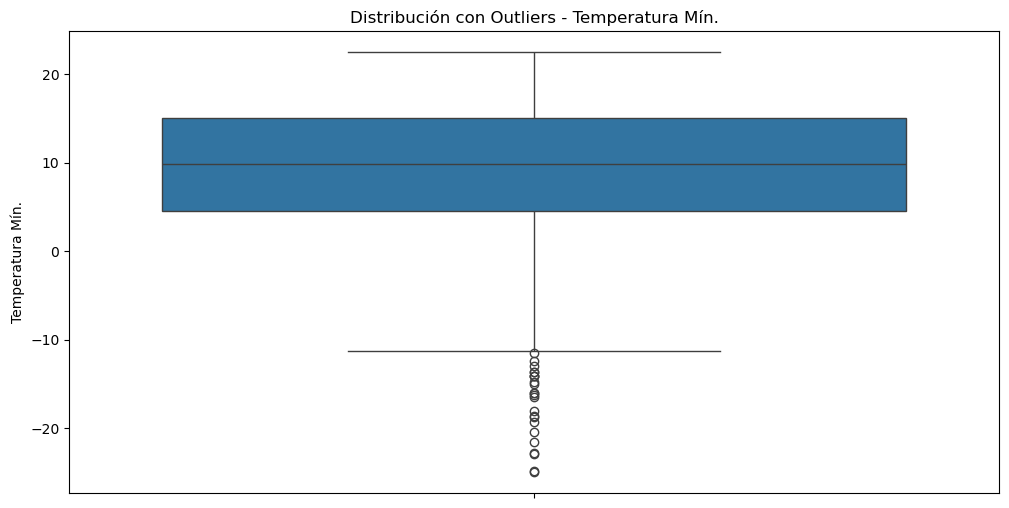

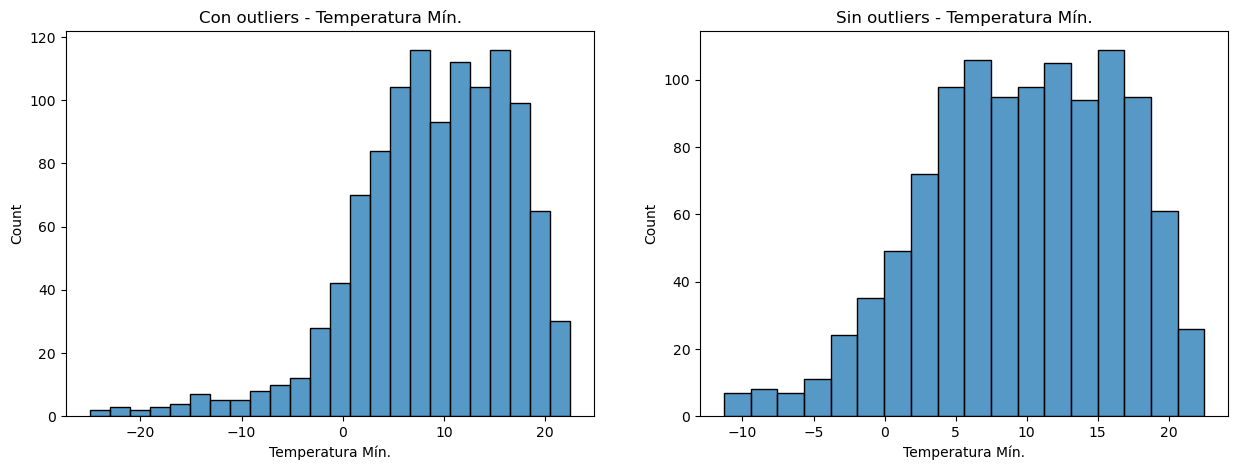

In [103]:
# Analizar outliers para múltiples variables
variables = ['Temperatura', 'Temperatura Máx.', 'Temperatura Mín.']

for var in variables:
    # Boxplots con outliers marcados
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df_91_20, y=var)
    plt.title(f'Distribución con Outliers - {var}')
    plt.show()
    
    # Crear el df sin outliers
    df_sin_outliers = df_91_20.copy()
    outliers = detect_outliers_iqr(df_91_20, var)
    df_sin_outliers = df_sin_outliers.drop(outliers.index)

    # Histogramas antes y después de remover outliers
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    sns.histplot(data=df_91_20, x=var, ax=ax1)
    ax1.set_title(f'Con outliers - {var}')
    sns.histplot(data=df_sin_outliers, x=var, ax=ax2) 
    ax2.set_title(f'Sin outliers - {var}')
    plt.show()

### Análisis

In [104]:
# Ejemplo de análisis contextual
def analyze_outliers_context(outliers_df, variable):
    print(f"Análisis de outliers para {variable}:")
    print("\nEstadísticas descriptivas:")
    print(outliers_df[variable].describe())

    print("\nDistribución por estación:")
    print(outliers_df.groupby('Estación')[variable].count())
    
    print("\nDistribución temporal:")
    print(outliers_df.groupby('Mes')[variable].count())

# Variables
variables = ['Temperatura', 'Temperatura Máx.', 'Temperatura Mín.']
outliers = detect_outliers_iqr(df_91_20, var)

for var in variables:
    analyze_outliers_context(outliers, var)

Análisis de outliers para Temperatura:

Estadísticas descriptivas:
count    24.0000
mean    -12.9625
std       4.0545
min     -20.9000
25%     -15.2750
50%     -11.7000
75%      -9.8750
max      -7.0000
Name: Temperatura, dtype: float64

Distribución por estación:
Estación
BASE BELGRANO II    9
BASE ESPERANZA      3
BASE MARAMBIO       6
BASE ORCADAS        2
BASE SAN MARTÍN     4
Name: Temperatura, dtype: int64

Distribución temporal:
Mes
Abr    2
Ago    5
Jul    5
Jun    4
Mar    1
May    2
Nov    1
Oct    1
Sep    3
Name: Temperatura, dtype: int64
Análisis de outliers para Temperatura Máx.:

Estadísticas descriptivas:
count    24.000000
mean     -9.012500
std       4.303316
min     -17.500000
25%     -11.325000
50%      -7.350000
75%      -5.950000
max      -3.200000
Name: Temperatura Máx., dtype: float64

Distribución por estación:
Estación
BASE BELGRANO II    9
BASE ESPERANZA      3
BASE MARAMBIO       6
BASE ORCADAS        2
BASE SAN MARTÍN     4
Name: Temperatura Máx., dtype: in

### Conclusiones y evaluaiones sobre outliers
En el análisis de outliers por variable, encontramos diferentes patrones de valores atípicos. Para la temperatura general, los outliers se distribuyen en ambos extremos de la distribución. En el caso de la temperatura máxima, se observa una mayor concentración de valores atípicos en el extremo superior, mientras que para la temperatura mínima los outliers tienden a concentrarse en los valores más bajos. Esta distribución sugiere una asimetría natural en el comportamiento de los extremos térmicos.Las causas de estos valores atípicos pueden atribuirse a diversos factores. Los eventos climáticos extremos, como olas de calor o frío intenso, son una causa natural principal. También pueden deberse a errores en los instrumentos de medición o en el proceso de registro de datos. Los cambios estacionales pronunciados y la influencia de fenómenos meteorológicos específicos como frentes fríos o cálidos intensos también pueden generar estos valores extremos.
El impacto de estos outliers en el análisis es significativo. Afectan directamente las medidas de tendencia central y pueden distorsionar la interpretación de la variabilidad de los datos. Las correlaciones entre variables también pueden verse sesgadas por estos valores extremos, lo que podría llevar a conclusiones incorrectas si no se manejan adecuadamente. Además, estos valores atípicos pueden afectar la precisión de cualquier modelo estadístico que se intente ajustar a los datos.

### Medidas a tomar
Para el tratamiento de estos outliers, se recomienda un enfoque equilibrado. En análisis generales, el método de recorte (clipping) resulta apropiado ya que mantiene la estructura general de los datos mientras controla el efecto de los valores extremos. Sin embargo, es importante evaluar cada caso en su contexto específico, considerando factores temporales y geográficos, para determinar si corresponden a eventos climáticos reales o a errores de medición. Se sugiere mantener un registro detallado de los casos extremos para análisis posteriores y posibles estudios de eventos climáticos excepcionales.



---

## Preguntas a responder

### ¿Cómo varía la amplitud térmica de acuerdo a las estaciones del año?

In [107]:
#Primero eliminamos las filas con datos faltantes en las columnas de temperatura para evitar que afecten el cálculo de la amplitud térmica.

df_temp = df_91_20.dropna(subset=['Temperatura Máx.', 'Temperatura Mín.']).copy()
df_temp['Amplitud térmica'] = df_temp['Temperatura Máx.'] - df_temp['Temperatura Mín.']

In [108]:
#Definimos una función para asignar la estación del año según el mes.
def mes_a_estacion(mes):
    if mes in ['Dic', 'Ene', 'Feb']:
        return 'Verano'
    elif mes in ['Mar', 'Abr', 'May']:
        return 'Otoño'
    elif mes in ['Jun', 'Jul', 'Ago']:
        return 'Invierno'
    elif mes in ['Sep', 'Oct', 'Novi']:
        return 'Primavera'
df_91_20['Estación_año'] = df_91_20['Mes'].apply(mes_a_estacion)

promedios = df_temp.groupby('Estación_año')['Amplitud térmica'].mean().sort_values()
print(promedios)

Estación_año
Otoño        11.361348
Invierno     11.722143
Verano       12.562366
Primavera    12.710638
Name: Amplitud térmica, dtype: float64


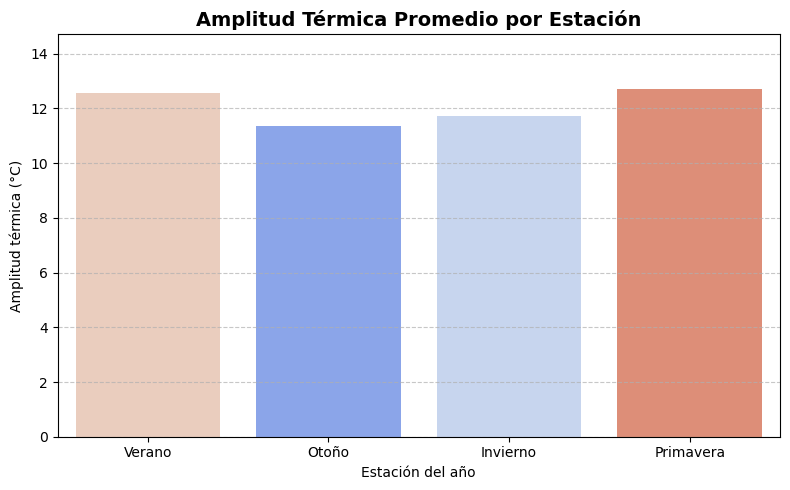

In [110]:
#Graficamos.
orden_estaciones = ['Verano', 'Otoño', 'Invierno', 'Primavera']

plt.figure(figsize=(8, 5))
sns.barplot(x=promedios.index, y=promedios.values, hue=promedios.index, order=orden_estaciones, palette='coolwarm', legend=False)

plt.title('Amplitud Térmica Promedio por Estación', fontsize=14, weight='bold')
plt.ylabel('Amplitud térmica (°C)')
plt.xlabel('Estación del año')
plt.ylim(0, max(promedios.values) + 2)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### ¿En qué meses se observan los valores más extremos de temperatura, humedad, viento y precipitación?

In [113]:
# Agrupamos por mes y calculamos la media para cada variable
medias_mensuales = df_91_20.groupby('Mes').agg({
    'Temperatura': 'mean',
    'Temperatura Máx.': 'mean', 
    'Temperatura Mín.': 'mean',
    'Humedad relativa': 'mean',
    'Viento': 'mean',
    'Precipitación': 'mean'
}).round(4)

# Encontramos los valores máximos y mínimos para cada variable
maximos = medias_mensuales.idxmax()
minimos = medias_mensuales.idxmin()

print("Valores máximos por mes:")
for variable, mes in maximos.items():
    valor = medias_mensuales.loc[mes, variable]
    print(f"{variable}: {valor} en {mes}")

print("\nValores mínimos por mes:")
for variable, mes in minimos.items():
    valor = medias_mensuales.loc[mes, variable]
    print(f"{variable}: {valor} en {mes}")


Valores máximos por mes:
Temperatura: 21.4688 en Ene
Temperatura Máx.: 27.924 en Ene
Temperatura Mín.: 15.371 en Ene
Humedad relativa: 76.2543 en May
Viento: 15.2847 en Nov
Precipitación: 99.6591 en Ene

Valores mínimos por mes:
Temperatura: 7.5105 en Jul
Temperatura Máx.: 13.8083 en Jul
Temperatura Mín.: 2.1649 en Jul
Humedad relativa: 61.443 en Nov
Viento: 10.7593 en May
Precipitación: 31.2744 en Jul


In [117]:
# Agrupamos por mes y seleccionamos el máximo y mínimo para cada variable
extremos_mensuales = df_91_20.groupby('Mes', observed=False).agg({
    'Temperatura': ['max', 'min'],
    'Temperatura Máx.': ['max', 'min'],
    'Temperatura Mín.': ['max', 'min'], 
    'Humedad relativa': ['max', 'min'],
    'Viento': ['max', 'min'],
    'Precipitación': ['max', 'min']
}).round(4)

# Encontramos los valores máximos y mínimos absolutos para cada variable
maximos_absolutos = extremos_mensuales.xs('max', axis=1, level=1).idxmax()
minimos_absolutos = extremos_mensuales.xs('min', axis=1, level=1).idxmin()

print("Valores máximos absolutos por mes:")
for variable, mes in maximos_absolutos.items():
    valor = extremos_mensuales.xs('max', axis=1, level=1).loc[mes, variable]
    print(f"{variable}: {valor} en {mes}")

print("\nValores mínimos absolutos por mes:")
for variable, mes in minimos_absolutos.items():
    valor = extremos_mensuales.xs('min', axis=1, level=1).loc[mes, variable]
    print(f"{variable}: {valor} en {mes}")


Valores máximos absolutos por mes:
Temperatura: 28.3 en Ene
Temperatura Máx.: 35.5 en Ene
Temperatura Mín.: 22.5 en Ene
Humedad relativa: 90.2 en Ene
Viento: 36.5 en Dic
Precipitación: 277.9 en Oct

Valores mínimos absolutos por mes:
Temperatura: -20.9 en Jul
Temperatura Máx.: -17.5 en Jul
Temperatura Mín.: -25.0 en Jul
Humedad relativa: 25.7 en Jul
Viento: 3.9 en Abr
Precipitación: 0.0 en Jun


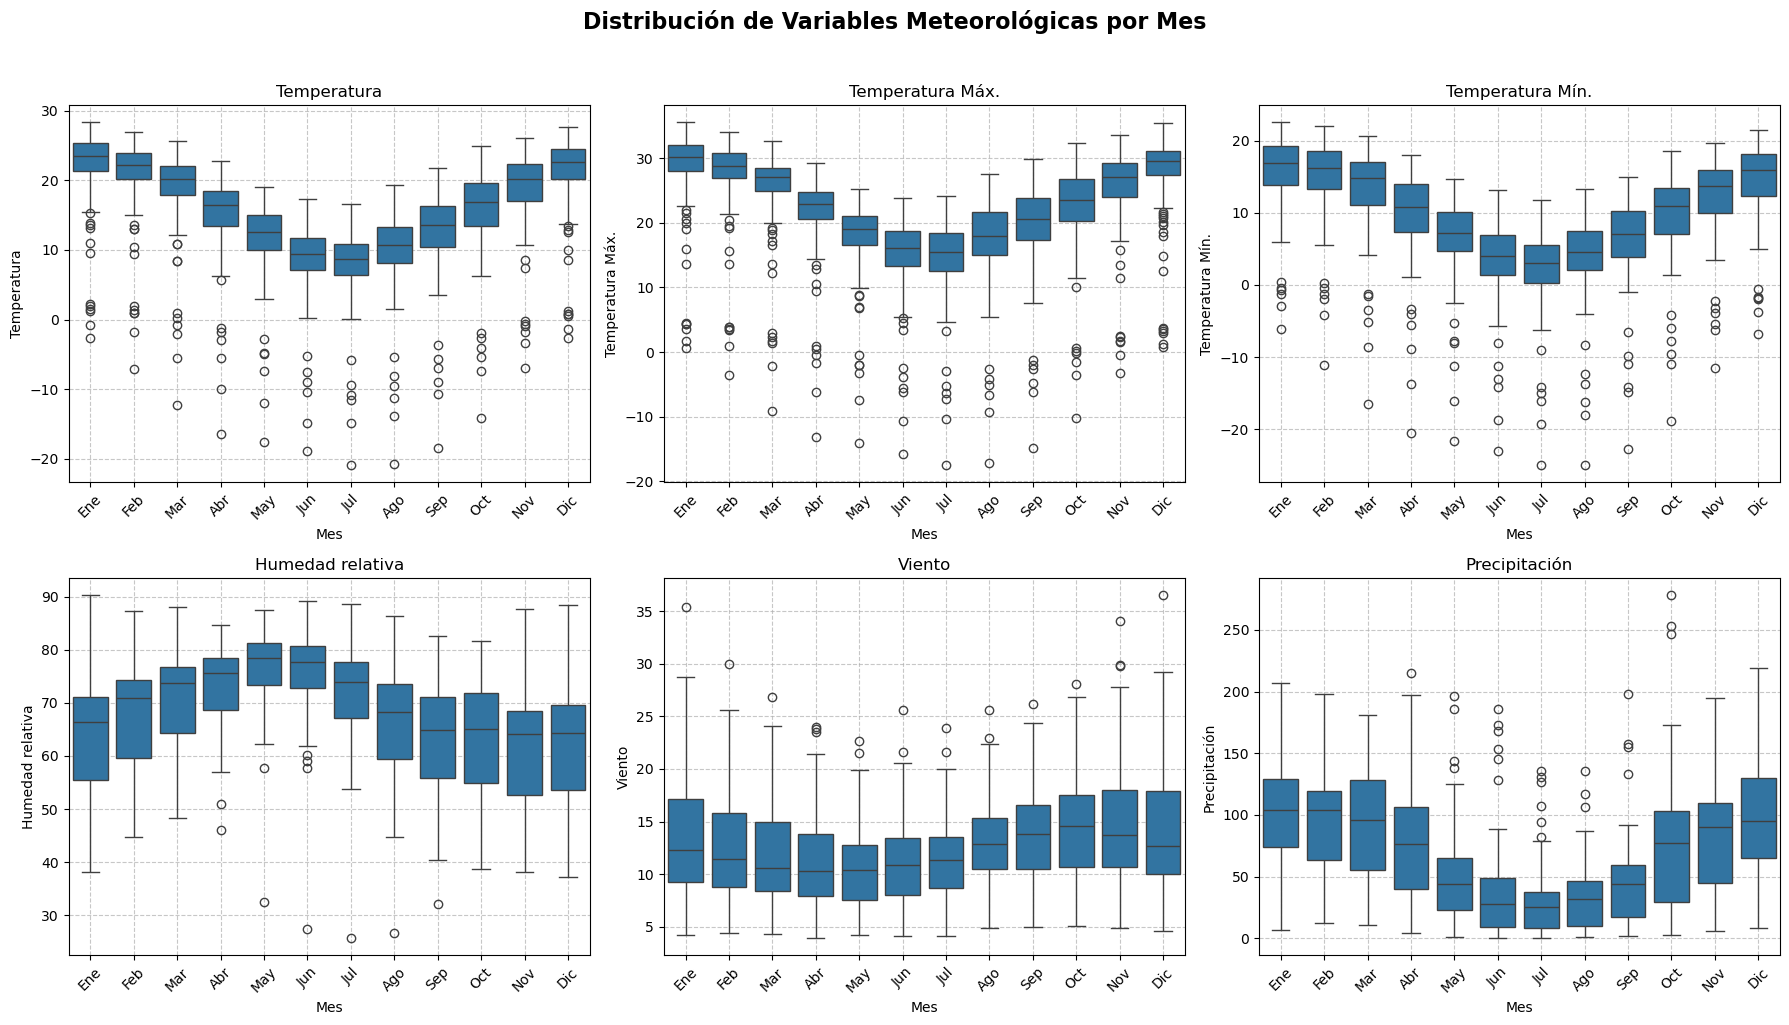

In [115]:
# Graficamos
# Creamos una figura con subplots para cada variable
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Distribución de Variables Meteorológicas por Mes', fontsize=16, weight='bold', y=1.02)

# Aplanamos los ejes para iterar más fácilmente
axes_flat = axes.flatten()

# Variables a graficar
variables = ['Temperatura', 'Temperatura Máx.', 'Temperatura Mín.', 
            'Humedad relativa', 'Viento', 'Precipitación']

# Definimos el orden cronológico de los meses
orden_meses = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']

# Reordenamos los meses en el dataframe
df_91_20['Mes'] = pd.Categorical(df_91_20['Mes'], categories=orden_meses, ordered=True)

# Creamos un boxplot para cada variable
for i, variable in enumerate(variables):
    sns.boxplot(data=df_91_20, x='Mes', y=variable, ax=axes_flat[i])
    axes_flat[i].set_title(variable)
    axes_flat[i].grid(True, linestyle='--', alpha=0.7)
    axes_flat[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


#### Análisis por variable
Las **temperaturas** muestran sus valores máximos durante el verano, con la temperatura máxima alcanzando picos de hasta más de 35°C, mientras que la temperatura mínima llega a poco más de 22°C en los días más cálidos. En contraste, durante el invierno se registran los valores más bajos, con mínimas que pueden descender hasta -25°C y máximas que apenas alcanzan los -17°C o un poco menos en los días más fríos. La temperatura media refleja este patrón estacional, oscilando entre aproximadamente -21°C en su punto más bajo y poco más de 27°C en su punto más alto.

La **humedad relativa** presenta su máximo valor en torno al 75% durante los meses de invierno, particularmente en junio y julio, mientras que sus mínimos se sitúan alrededor del 65% durante los meses más secos y cálidos del verano, especialmente en diciembre y enero. A pesar de esta variación, los niveles de humedad se mantienen relativamente altos durante todo el año, con una leve disminución en los meses de verano. Esta relación inversa con la temperatura es un patrón característico del clima de la región.

El **viento** muestra sus valores más intensos durante el verano, con máximas que superan los 36 km/h, especialmente en diciembre y enero. Los períodos de menor intensidad se registran durante el otoño e invierno, con mínimas por debajo de los 5 km/h, lo que indica una variación significativa en la intensidad del viento a lo largo del año.

Las **precipitaciones** exhiben una gran variabilidad, con valores máximos que superan los 100mm mensuales durante el verano y principios de otoño, particularmente en enero con mas de 117mm. Los mínimos se registran con valores cercanos a 0mm, principalmente durante los meses de invierno, aunque la presencia de valores atípicos sugiere que pueden ocurrir eventos de lluvia intensa en cualquier época del año.

